In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, ReLU, Dot, Lambda, Embedding, Flatten
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from pathlib import Path
import os
import requests
import zipfile

In [ ]:
# Download and extract the MovieLens 32M dataset
url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
zip_filename = "ml-32m.zip"
extract_folder = "ml-32m"
target_folder = "data"

response = requests.get(url, stream=True)
with open(zip_filename, "wb") as f:
    for chunk in response.iter_content(chunk_size=1024*1024):
        if chunk:
            f.write(chunk)

with zipfile.ZipFile(zip_filename, "r") as zip_ref:
    zip_ref.extractall(".")

if os.path.exists(target_folder):
    print(f"Folder '{target_folder}' already exists, removing it...")
    import shutil
    shutil.rmtree(target_folder)

os.rename(extract_folder, target_folder)
print(f"Folder renamed to '{target_folder}'.")

os.remove(zip_filename)
print("Cleaned up zip file.")


In [3]:
IMAGE_PATH = Path('./images/deep_mf/')
IMAGE_PATH.mkdir(parents=True, exist_ok=True)

# Function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGE_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches="tight")
    print(f"Figure saved to: {path}")

## Setup model parameters

In [4]:
MAX_RATING = 5.0  # MAX_RATING: maximum rating value in the dataset (5.0)
MU = 1.0e-6  # MU: regularization parameter (1.0e-6)
N_USERS = 1000  # N_USERS: number of users to consider (1000)
N_MOVIES = 1000  # N_MOVIES: number of movies to consider (1000)

np.random.seed(42)

## Data preparation ##

In [5]:
#load data
data = pd.read_csv('data/ratings.csv')

In [6]:
data.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [7]:
user_counts = data['userId'].value_counts()
top_users = user_counts.head(N_USERS).index
data_sub = data[data['userId'].isin(top_users)]

movie_counts = data_sub['movieId'].value_counts()
top_movies = movie_counts.head(N_MOVIES).index
data_sub = data_sub[data_sub['movieId'].isin(top_movies)].copy()

user_index = pd.Index(sorted(data_sub['userId'].unique()))
movie_index = pd.Index(sorted(data_sub['movieId'].unique()))
user_id_to_idx = {u: i for i, u in enumerate(user_index)}
movie_id_to_idx = {m: i for i, m in enumerate(movie_index)}
data_sub['user_idx'] = data_sub['userId'].map(user_id_to_idx).astype('int32')
data_sub['movie_idx'] = data_sub['movieId'].map(movie_id_to_idx).astype('int32')

Y_df = (
    data_sub
    .pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
    .sort_index()
    .sort_index(axis=1)
)

num_users = len(user_index)
num_items = len(movie_index)

In [9]:
Y_df.head()

movieId,1,2,6,10,11,16,19,21,25,32,...,134853,139385,139644,142488,148626,164179,166528,168250,168252,176371
userId,,,,,,,,,,,,,,,,,,,,,
28,4.0,3.0,3.0,3.0,5.0,3.0,0.0,4.0,3.0,5.0,...,4.5,5.0,4.5,5.0,5.0,4.0,4.0,0.0,4.0,5.0
188,4.0,4.0,5.0,0.0,3.0,5.0,3.5,4.5,2.5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265,5.0,4.0,0.0,4.0,0.0,4.0,0.0,3.5,0.0,5.0,...,0.0,2.5,3.5,3.5,5.0,5.0,1.5,4.0,4.5,0.0
1048,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.5,5.0,...,5.0,4.0,0.0,0.0,3.0,3.5,3.0,4.5,3.5,4.0
1411,4.0,3.5,4.0,3.5,3.5,3.5,0.0,3.5,3.0,4.5,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare the trainable matrices
Create train and test splits from the interaction matrix Y:
- For each user, hold out the last interaction as the test item and use remaining interactions for training.
- Build a positive sample set (observed interactions) and draw negative samples from unobserved entries (negative sampling).

The training inputs are:
- X_user_train: user interaction vectors (Yi*)
- X_item_train: item interaction vectors (Yj^T)
- y_train: labels (ratings for positives, 0 for negatives)
    

In [ ]:
Y = Y_df.to_numpy(dtype=np.float32)

num_users, num_items = Y.shape

train_Y = np.zeros_like(Y)
test_pairs = []  # (user, test_item)

# leave last interaction of each user for testing
for u in range(num_users):
    items = np.nonzero(Y[u])[0]  # all items this user interacted with
    test_item = items[-1]            # hold out the last one
    train_items = items[:-1]          # others for training
    train_Y[u, train_items] = Y[u, train_items]
    test_pairs.append((u, test_item))

# Negative sampling for training 
user_idx_pos, item_idx_pos = np.nonzero(train_Y)
y_pos = train_Y[user_idx_pos, item_idx_pos]

neg_ratio = 1.0
zero_positions = np.argwhere(train_Y == 0)
num_neg = int(len(user_idx_pos) * neg_ratio)
num_neg = min(num_neg, len(zero_positions))
neg_sample_idx = np.random.choice(len(zero_positions), num_neg, replace=False)
user_idx_neg, item_idx_neg = zero_positions[neg_sample_idx].T
y_neg = np.zeros(len(user_idx_neg))

# Combine positives and negatives
user_idx_all = np.concatenate([user_idx_pos, user_idx_neg])
item_idx_all = np.concatenate([item_idx_pos, item_idx_neg])
y_all = np.concatenate([y_pos, y_neg])

# Prepare training inputs
X_user_train = train_Y[user_idx_all, :]        # user interaction vectors
X_item_train = train_Y[:, item_idx_all].T      # item interaction vectors
y_train = y_all



## Prepare the evaluation data

In [9]:
num_negatives = 100
test_data = []  # (user, true_item, neg_items)

for (u, true_item) in test_pairs:
    all_items = np.arange(num_items)
    interacted = np.nonzero(Y[u])[0]
    non_interacted = np.setdiff1d(all_items, interacted)
    if len(non_interacted) < num_negatives:
        continue  # skip edge cases
    neg_items = np.random.choice(non_interacted, size=num_negatives, replace=False)
    test_data.append((u, true_item, neg_items))

print(f"Prepared {len(test_data)} users for evaluation.")

Prepared 952 users for evaluation.


## Custom Loss ##

In [10]:
def normalized_cross_entropy_loss(y_true, y_pred):
    """
    Implements the loss from Equation 12
    y_true: actual rating in [0, MAX_RATING]
    y_pred: predicted probability
    """
    y_true_norm = y_true / MAX_RATING
    
    y_pred = K.clip(y_pred, MU, 1.0 - MU)

    term_1 = y_true_norm * K.log(y_pred)
    term_2 = (1 - y_true_norm) * K.log(1 - y_pred)
    nce_loss = -(term_1 + term_2)
    
    return K.mean(nce_loss)

## Build Model

skip this step and load up the model weight from the DeepMF_model file

In [ ]:
def DeepMF(num_users, num_items, hidden_units=[512, 256, 128]):
    """
    Deep Matrix Factorization (DeepMF)
    Inputs:
        - user_input: Yi* (interaction vector for user i)
        - item_input: Y*j (interaction vector for item j)
    Output:
        - Predicted relevance (Ŷ_ij)
    """
    
    # user tower
    user_input = Input(shape=(num_items,), dtype='float32', name='user_input')  # Yi*
    u = user_input
    for i, units in enumerate(hidden_units):
        u = Dense(units, activation='relu', kernel_initializer='he_normal', name=f'user_dense_{i+1}')(u)

    # item tower    
    item_input = Input(shape=(num_users,), dtype='float32', name='item_input')  # Y*j
    v = item_input
    for i, units in enumerate(hidden_units):
        v = Dense(units, activation='relu', kernel_initializer='he_normal', name=f'item_dense_{i+1}')(v)

    # cosine sim
    cos = Dot(axes=1, normalize=True, name='cosine_similarity')([u, v])
    y_pred = Lambda(lambda x: K.clip(MU,x,1 - MU), name="Y_hat_o_Eq13")(cos)

    model = tf.keras.Model(inputs=[user_input, item_input], outputs=y_pred, name='DeepMF')
    return model

In [32]:
model = DeepMF(N_USERS, N_MOVIES)

In [35]:
model.compile(optimizer='adam', loss=normalized_cross_entropy_loss, metrics=['accuracy'])

In [36]:
model.summary()

Model: "DeepMF"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1000)]               0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1000)]               0         []                            
                                                                                                  
 user_dense_1 (Dense)        (None, 512)                  512512    ['user_input[0][0]']          
                                                                                                  
 item_dense_1 (Dense)        (None, 512)                  512512    ['item_input[0][0]']          
                                                                                             

## Training

In [37]:
history = model.fit(
    x=[X_user_train, X_item_train],
    y=y_train,
    batch_size=256,
    epochs=50,
    validation_split=0.1
)

Epoch 1/50
3516/3516 [==============================] - 28s 8ms/step - loss: 0.6065 - accuracy: 0.2127 - val_loss: 0.3879 - val_accuracy: 0.8723
Epoch 2/50
3516/3516 [==============================] - 28s 8ms/step - loss: 0.5925 - accuracy: 0.2203 - val_loss: 0.4061 - val_accuracy: 0.8510
Epoch 3/50
3516/3516 [==============================] - 27s 8ms/step - loss: 0.5892 - accuracy: 0.2220 - val_loss: 0.3985 - val_accuracy: 0.8481
Epoch 4/50
3516/3516 [==============================] - 28s 8ms/step - loss: 0.5875 - accuracy: 0.2231 - val_loss: 0.3929 - val_accuracy: 0.8590
Epoch 5/50
3516/3516 [==============================] - 28s 8ms/step - loss: 0.5862 - accuracy: 0.2238 - val_loss: 0.4150 - val_accuracy: 0.8396
Epoch 6/50
3516/3516 [==============================] - 28s 8ms/step - loss: 0.5852 - accuracy: 0.2244 - val_loss: 0.4171 - val_accuracy: 0.8359
Epoch 7/50
3516/3516 [==============================] - 29s 8ms/step - loss: 0.5844 - accuracy: 0.2248 - val_loss: 0.4162 - val_ac

Figure saved to: images\deep_mf\deep_mf_training_loss.png


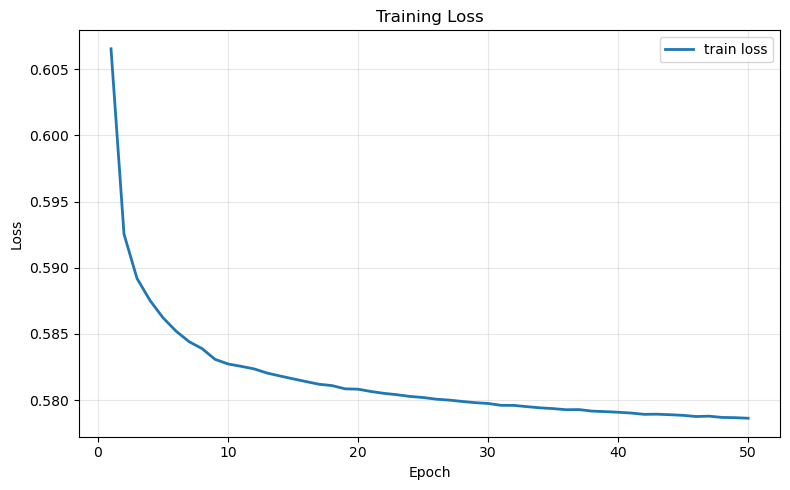

In [40]:
# Plot training and validation loss from the History object
hist = history.history
loss = hist.get('loss')

if loss is None:
    print("No training loss found in `history`.")
else:
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, label='train loss', color='tab:blue', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    save_fig('deep_mf_training_loss')
    plt.show()

In [41]:
model.save('DeepMF_model')

INFO:tensorflow:Assets written to: DeepMF_model\assets


INFO:tensorflow:Assets written to: DeepMF_model\assets


In [12]:
model = tf.keras.models.load_model(
    'DeepMF_model',
    custom_objects={'normalized_cross_entropy_loss': normalized_cross_entropy_loss}
)

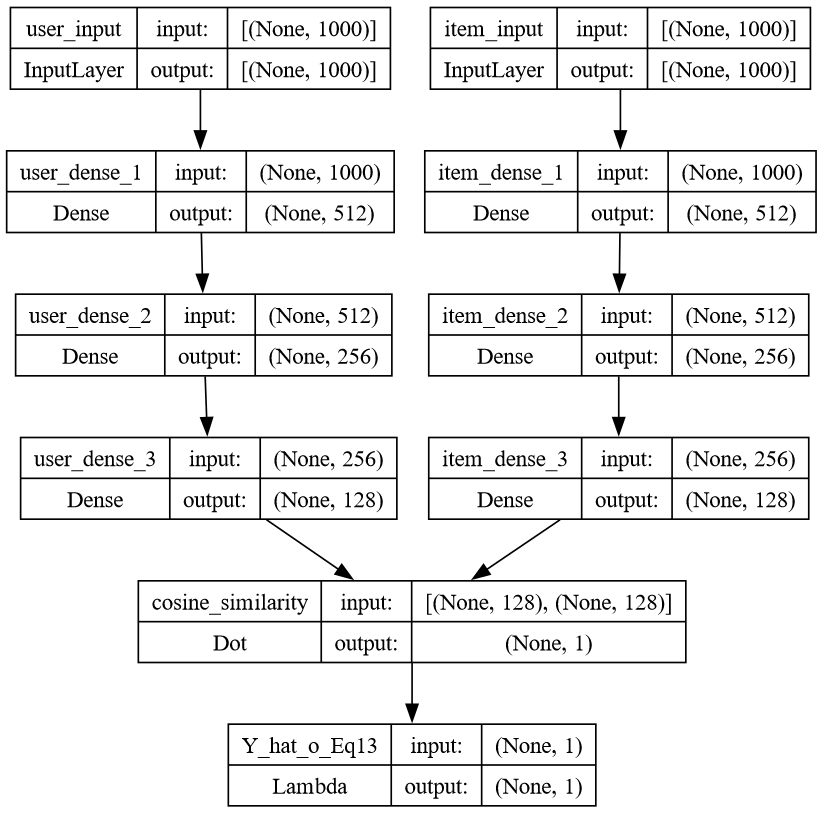

In [ ]:
plot_model(
    model,
    to_file='images\deep_mf\deep_mf_architecture.png',
    show_shapes=True,                   
    show_layer_names=True,              
    expand_nested=True,                 
    dpi=120
)

## Evaliate Model ##
HR@K and NDCG@K

In [45]:
def evaluate_deepmf(model, test_data, Y, K=10):
    hits, ndcgs = [], []

    for (u, true_item, neg_items) in test_data:
        # Candidate items = 1 positive + 100 negatives
        items = np.concatenate(([true_item], neg_items))

        # Prepare user and item inputs
        user_vecs = np.repeat(Y[u].reshape(1, -1), len(items), axis=0)  # (101, num_items)
        item_vecs = Y[:, items].T                                       # (101, num_users)

        # Predict scores
        scores = model.predict([user_vecs, item_vecs], verbose=0).flatten()

        # Rank items by predicted score
        ranked_indices = np.argsort(-scores)
        ranked_items = items[ranked_indices]

        # Rank position of the true item
        rank = np.where(ranked_items == true_item)[0][0] + 1  # 1-based

        # Compute metrics
        hit = 1 if rank <= K else 0
        ndcg = 1 / np.log2(rank + 1) if rank <= K else 0

        hits.append(hit)
        ndcgs.append(ndcg)

    hr = np.mean(hits)
    ndcg = np.mean(ndcgs)
    return hr, ndcg


In [46]:
hr, ndcg = evaluate_deepmf(model, test_data, Y, K=10)
print(f"HR@10 = {hr:.4f}, NDCG@10 = {ndcg:.4f}")

HR@10 = 0.4832, NDCG@10 = 0.2911
